# Blob Detection using OpenCV Library

In [1]:
import cv2
import numpy as np

image = cv2.imread('flowers.jpg')
if image is None:
    raise ValueError("Image not found. Ensure the filename is correct.")

detector = cv2.SimpleBlobDetector_create()

# Detect blobs.
keypoints = detector.detect(image)

# Draw detected blobs
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
blank = np.zeros((1, 1))  
blobs = cv2.drawKeypoints(image, keypoints, blank, (0, 0, 255),
                          cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv2.imwrite('flower_with_blobs.jpg', blobs)
cv2.imshow("Blobs Detected", blobs)

# Blob Detection Using Custom LoG Function

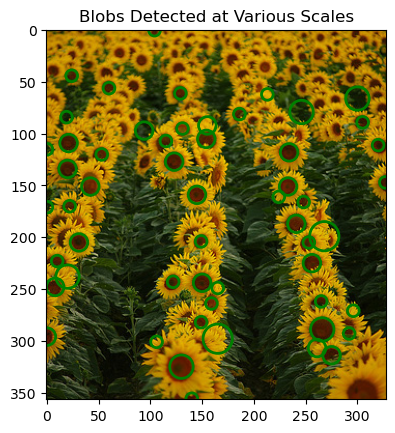

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, maximum_filter, convolve
from PIL import Image
import matplotlib.patches as patches

# Function to generate a Gaussian filter
def create_gaussian_kernel(dimensions: tuple[int, int], stddev: float = 0.5) -> np.ndarray:
    m, n = [(dim - 1.) / 2. for dim in dimensions]
    y, x = np.ogrid[-m:m + 1, -n:n + 1]
    kernel = np.exp(-(x * x + y * y) / (2. * stddev ** 2))
    kernel[kernel < np.finfo(kernel.dtype).eps * kernel.max()] = 0
    return kernel / kernel.sum() if kernel.sum() != 0 else kernel

# Apply custom Gaussian blur to an image using a Gaussian filter
def gaussian_filter_(image_array: np.ndarray, filter_size: int, stddev: float = 0.5) -> np.ndarray:
    gaussian_filter_kernel = create_gaussian_kernel((filter_size, filter_size), stddev)
    blurred_image = convolve(image_array, gaussian_filter_kernel)
    return blurred_image

# Function to calculate the Laplacian of a Gaussian (LoG)
def calculate_log(image_data, stddev):
    # Perform Gaussian smoothing
    blurred_image = gaussian_filter(image_data, sigma=stddev)
    # Define Laplacian kernel
    laplacian_kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    # Perform convolution with the Laplacian kernel
    laplacian_result = convolve(blurred_image, laplacian_kernel)
    log = (stddev ** 2) * laplacian_result
    #log = laplacian_result
    return log  # Scale the result by sigma^2 for normalization

# Function for detecting blobs across different scales
def detect_blobs_with_scale_space(grayscale_image, original_image, scales, threshold=0.03, min_size=5, max_size=20, proximity=10):
    fig, axis = plt.subplots(1)
    axis.imshow(original_image)
    
    # Create a list to store responses at different scales
    scale_responses = []
    sigma_levels = []
    
    # Calculate LoG for each scale and store the results
    for sigma in scales:
        log_result = calculate_log(grayscale_image, sigma)
        log_result = log_result ** 2  # Square the result to handle both positive and negative blobs
        scale_responses.append(log_result)
        sigma_levels.append(sigma)
    
    # Convert to a NumPy array for easier manipulation
    scale_responses = np.array(scale_responses)
    
    # Identify local maxima in 3D (scale-space) using maximum filtering
    neighborhood_shape = np.ones((3, 3, 3))  # 3x3x3 neighborhood for detecting maxima
    maxima_in_scale_space = maximum_filter(scale_responses, footprint=neighborhood_shape, mode='constant')
    
    # Locate local maxima where the scale-space values match the filtered maxima
    local_maxima = (scale_responses == maxima_in_scale_space)
    local_maxima[scale_responses < threshold] = 0  # Apply threshold to filter out weak blobs
    blob_coordinates = np.argwhere(local_maxima)
    
    # Store detected blobs in a list
    identified_blobs = []
    for coordinate in blob_coordinates:
        scale_idx, y, x = coordinate
        sigma = sigma_levels[scale_idx]
        blob_radius = sigma * np.sqrt(2)
        # Filter blobs based on size
        if min_size <= blob_radius <= max_size:
            identified_blobs.append((x, y, blob_radius, scale_responses[scale_idx, y, x], sigma))
    
    # Merge blobs that are close to each other based on proximity
    final_blobs = []
    for i, (x1, y1, r1, response1, sigma1) in enumerate(identified_blobs):
        merged = False
        for j, (x2, y2, r2, response2, sigma2) in enumerate(final_blobs):
            distance = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
            if distance < proximity:
                if response1 > response2:
                    final_blobs[j] = (x1, y1, r1, response1, sigma1)
                merged = True
                break
        if not merged:
            final_blobs.append((x1, y1, r1, response1, sigma1))
    
    # Visualize the detected blobs by drawing circles on the original image
    for (x, y, radius, _, sigma) in final_blobs:
        blob_circle = patches.Circle((x, y), radius, linewidth=2, edgecolor='green', facecolor='none')
        axis.add_patch(blob_circle)
    
    plt.title('Blobs Detected at Various Scales')
    plt.show()
    
    return original_image

# Load image and prepare grayscale and RGB versions
image_path = 'flowers.jpg'
rgb_image = np.array(Image.open(image_path).convert('RGB'))
grayscale_image = np.array(Image.open(image_path).convert('L')).astype(np.float64)

# Define the range of scales (sigma values) for blob detection
scale_range = [1,2,3,4,6,8,10,12]

# Set parameters for blob detection
min_blob_radius = 5  # Minimum blob size
max_blob_radius = 15  # Maximum blob size
blob_merge_distance = 15  # Proximity for merging nearby blobs
blob_threshold = 1700  # Threshold for blob detection

# Run blob detection and visualize the results
output_image = detect_blobs_with_scale_space(
    grayscale_image,
    rgb_image,
    scale_range,
    threshold=blob_threshold,
    min_size=min_blob_radius,
    max_size=max_blob_radius,
    proximity=blob_merge_distance
)
